In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json
import matplotlib as mpl

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [29]:
from surp import ViceModel, yields, subgiants
from surp import gce_math as gcem

import surp
import arya
from arya import COLORS

In [4]:
from singlezone import run_singlezone

In [5]:
subgiants_ha = subgiants[subgiants.high_alpha]

all_abundances = pd.read_csv("data_analysis/all_data.csv")

fiducial = ViceModel.from_saved("../models/C11_f0.2/model.json")

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

# Singlezone models

In [7]:
yp = surp.YieldParams.from_file("../models/C11_f0.2_Quadratic/yield_params.json")
surp.set_yields(yp)

sz_fiducial = run_singlezone()[1]

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   1.00e-03 MH^2 + 1.58e-03 MH +  1.31 × cristallo11             0                              
                    2.30e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [8]:
yp = surp.YieldParams.from_file("../models/C11_f0.2/yield_params.json")
surp.set_yields(yp)


sz_models = [
    run_singlezone(eta=0, t_end=13, tau_star=2, tau_sfh=5)[1],
    run_singlezone(eta=1, t_end=10, tau_star=2, tau_sfh=10)[1],
    run_singlezone(eta=9, t_end=3, tau_star=5, tau_sfh=3)[1],
    # sz_model(eta=15, t_end=5, tau_sfh=1)
]

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)
/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,


yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 1.55e-03 [M/H] or   1.31 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/outputs/output.py:131: UserWarning: agb c yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/users/PAS2232/aeyobd/VICE/vice/core

In [9]:
MoverH = np.linspace(-5, 0.5)
Z = gcem.MH_to_Z(MoverH)

y_total = gcem.calc_y(Z)
y_agb = gcem.calc_y(Z, kind="agb")
y_cc = gcem.calc_y(Z, kind="cc")
y_ia = gcem.calc_y(Z, kind="ia")

yo = gcem.calc_y(ele="o")

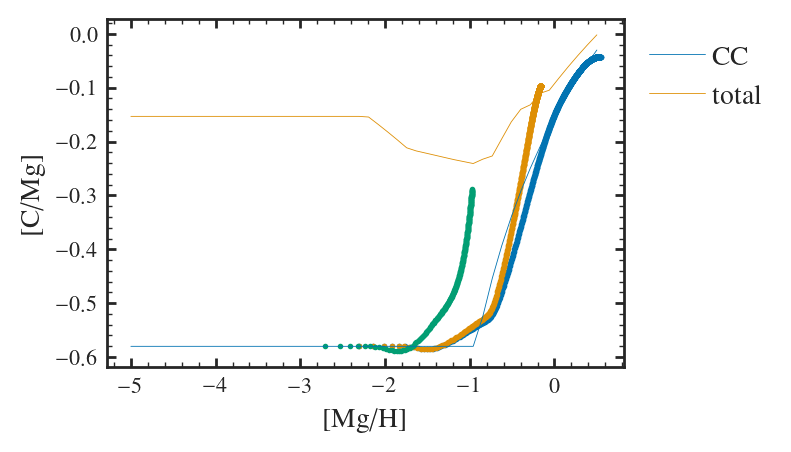

In [10]:
for h in sz_models:
    plt.scatter(h.O_H, h.C_O, s=1)

plt.plot(MoverH, gcem.abund_to_brak(y_cc/yo, "c", "o"), lw=0.3, label="CC")
plt.plot(MoverH, gcem.abund_to_brak(y_total/yo, "c", "o"), lw=0.3, label="total")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

arya.Legend(-1)

In [31]:
legend_key = {
    "RL": dict(label="HII regions", marker="o", color=COLORS[1]),
    "dwarf": dict(label="dwarf galaxies", marker="d", color=COLORS[3]),
    "star": dict(label="halo/thick disk stars", marker="*", color=COLORS[0]),
    "DLA": dict(label="dampled Lyman-$\\alpha$", marker="^", color=COLORS[6]),

}

legend_labels = {
    "RL": "HII regions"
}


# Amarsi19

In [30]:
def plot_cooh_errs(df, **kwargs):
    x = df["[o/h]"]
    y =  df["[c/o]"]
    xerr = df["[o/h]_err"]
    yerr = df["[c/o]_err"]
    filt = ~(np.isnan(xerr) | np.isnan(yerr))
    
    plt.errorbar(x[filt], y[filt], xerr=xerr[filt], yerr=yerr[filt], fmt="o", capsize=0, **kwargs)
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [33]:
amarsi19 = pd.read_csv(surp.DATA_DIR + "amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)
amarsi19["[o/h]"] = amarsi19["[O/H]3N"]
amarsi19["[c/h]"] = amarsi19["[C/H]3N"]
amarsi19["[c/o]"] = amarsi19["[c/h]"] - amarsi19["[o/h]"] 

amarsi19["[o/h]_err"] = amarsi19["e_[O/H]3N"]
amarsi19["[c/h]_err"] = amarsi19["e_[C/H]3N"]
amarsi19["[c/o]_err"] = amarsi19["[o/h]_err"] + amarsi19["[c/h]_err"] 
amarsi19["[o/fe]"] = -amarsi19["[Fe/H]3L"] + amarsi19["[o/h]"]
amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

/tmp/slurmtmp.27915119/ipykernel_534/2991333971.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amarsi19 = pd.read_csv(surp.DATA_DIR + "amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)


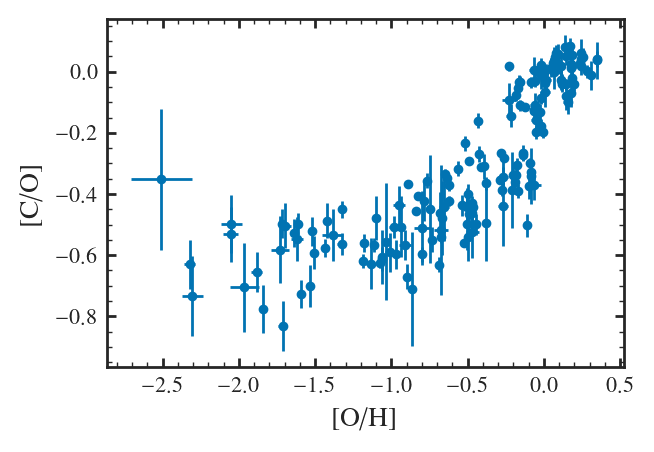

In [34]:
plot_cooh_errs(amarsi19)

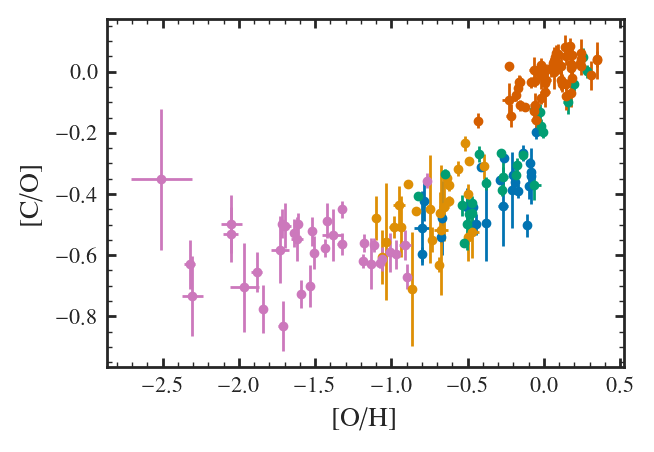

In [39]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plot_cooh_errs(amarsi19[filt])



Text(0, 0.5, '[C/O]')

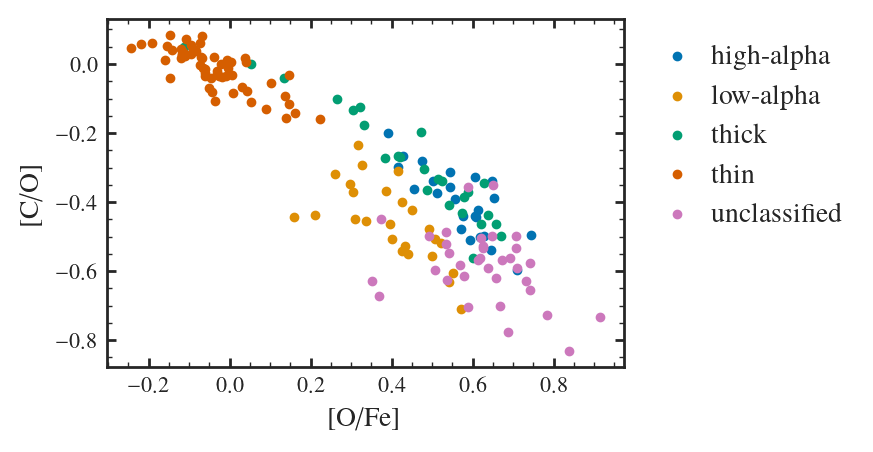

In [37]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plt.scatter(amarsi19[filt]["[o/fe]"], amarsi19[filt]["[c/o]"], label=pop)

arya.Legend(-1)
plt.xlabel("[O/Fe]")
plt.ylabel("[C/O]")

In [ ]:
mh_cut = -0.

In [27]:
def plot_amarsi19():
    color = COLORS[1]
    marker = "o"
    
    
    #plt.scatter(df["[o/h]"], df["[c/o]"], marker=marker, color=color, label="halo/thick disk stars")
    
    mh_cut = -0.3
    df_l = df[df["[o/h]"] < mh_cut]
    plt.scatter(df_l["[o/h]"], df_l["[c/o]"], marker=marker, color=color, label="halo/thick disk stars")
    

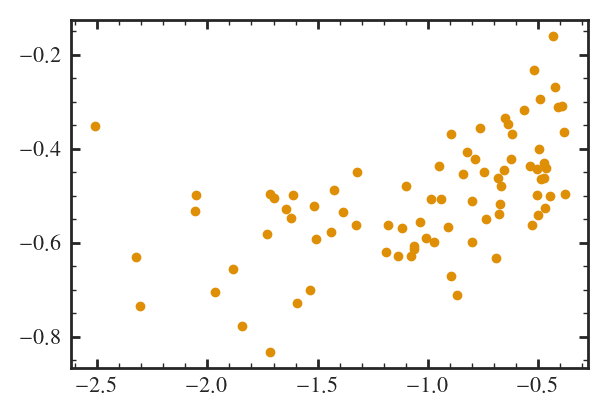

In [28]:
plot_amarsi19()

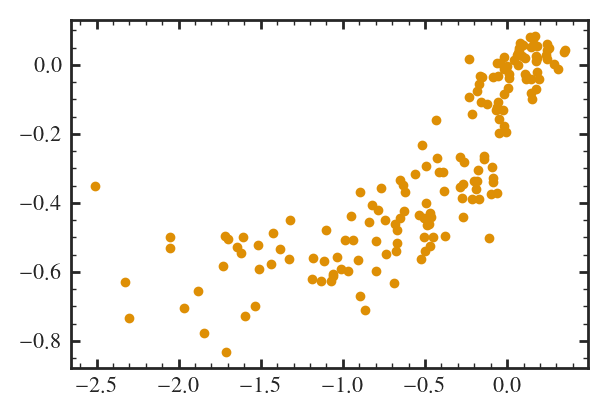

In [23]:
plot_amarsi19()

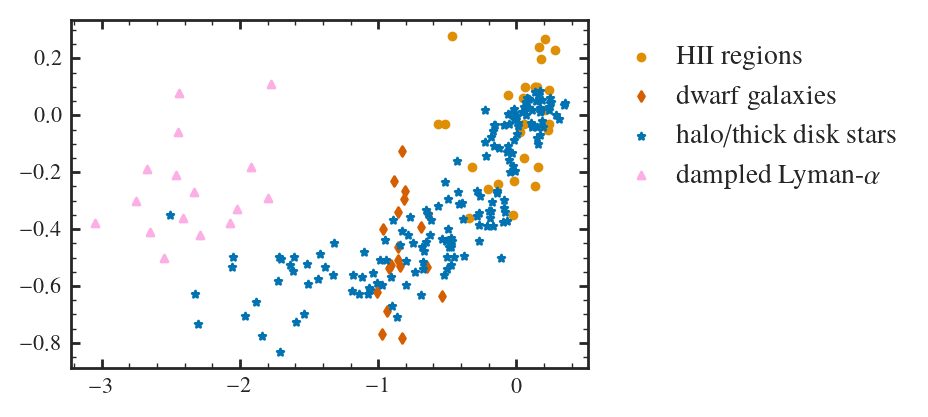

In [14]:
def plot_all():
    for key in ["RL", "dwarf", "star", "DLA"]:
        df = all_abundances[all_abundances.type == key]
        plt.scatter(df["[o/h]"], df["[c/o]"], **legend_key[key])
        
plot_all()
arya.Legend(-1)


In [15]:
def plot_errorbars():
    df = all_abundances[all_abundances.type == "star"]
    x_err = np.mean(df["[o/h]_err"])
    y_err = np.mean(df["[c/o]_err"])
    e_idx = np.intersect1d(df.index, [68, 36, 2, 82, 239])
    if len(e_idx) == 1:
        plt.errorbar(df["[o/h]"][e_idx], df["[c/o]"][e_idx], xerr=x_err, yerr=y_err, 
                     markersize=0, color=color, capsize=0)

In [15]:
plot_errorbars()

In [17]:
plt.scatter(df[idx_h]["[o/h]"], df[idx_h]["[c/o]"], c=df[idx_h].index)
i = 72
plt.scatter(df.loc[i]["[o/h]"], df.loc[i]["[c/o]"], s=5, fc="None", ec=COLORS[0])

NameError: name 'df' is not defined

-1.7141 -0.8314999999999999 0.033779411764705884 0.07255294117647057
-0.2682 -0.4403 0.01741259259259259 0.039125757575757564


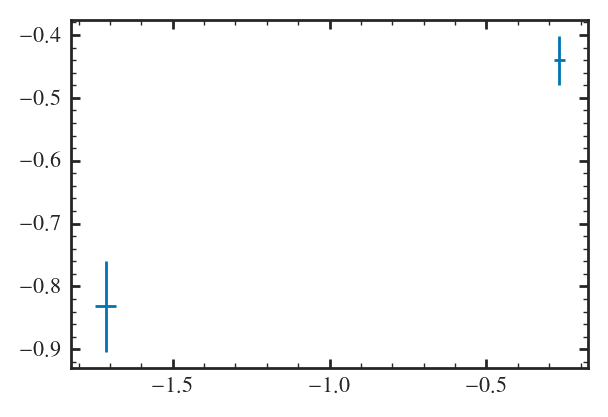

In [18]:
#plot errorbars on stars
cut_mh = -1
df = all_abundances[all_abundances.type == "star"]
idx_l = df["[o/h]"] < cut_mh
idx_h = ~idx_l
for j, idx in enumerate([idx_l, idx_h]):
    i = [257, 72][j]
    df_c = df.loc[idx]
    x = df_c["[o/h]"][i]
    y = df_c["[c/o]"][i]
    xerr = np.nanmean(df_c["[o/h]_err"])
    yerr = np.nanmean(df_c["[c/o]_err"])
    color=arya.style.COLORS[0]
    print(x, y, xerr, yerr)

    plt.errorbar(x, y, xerr=xerr, yerr=yerr, ms=0, capsize=0, color=color)

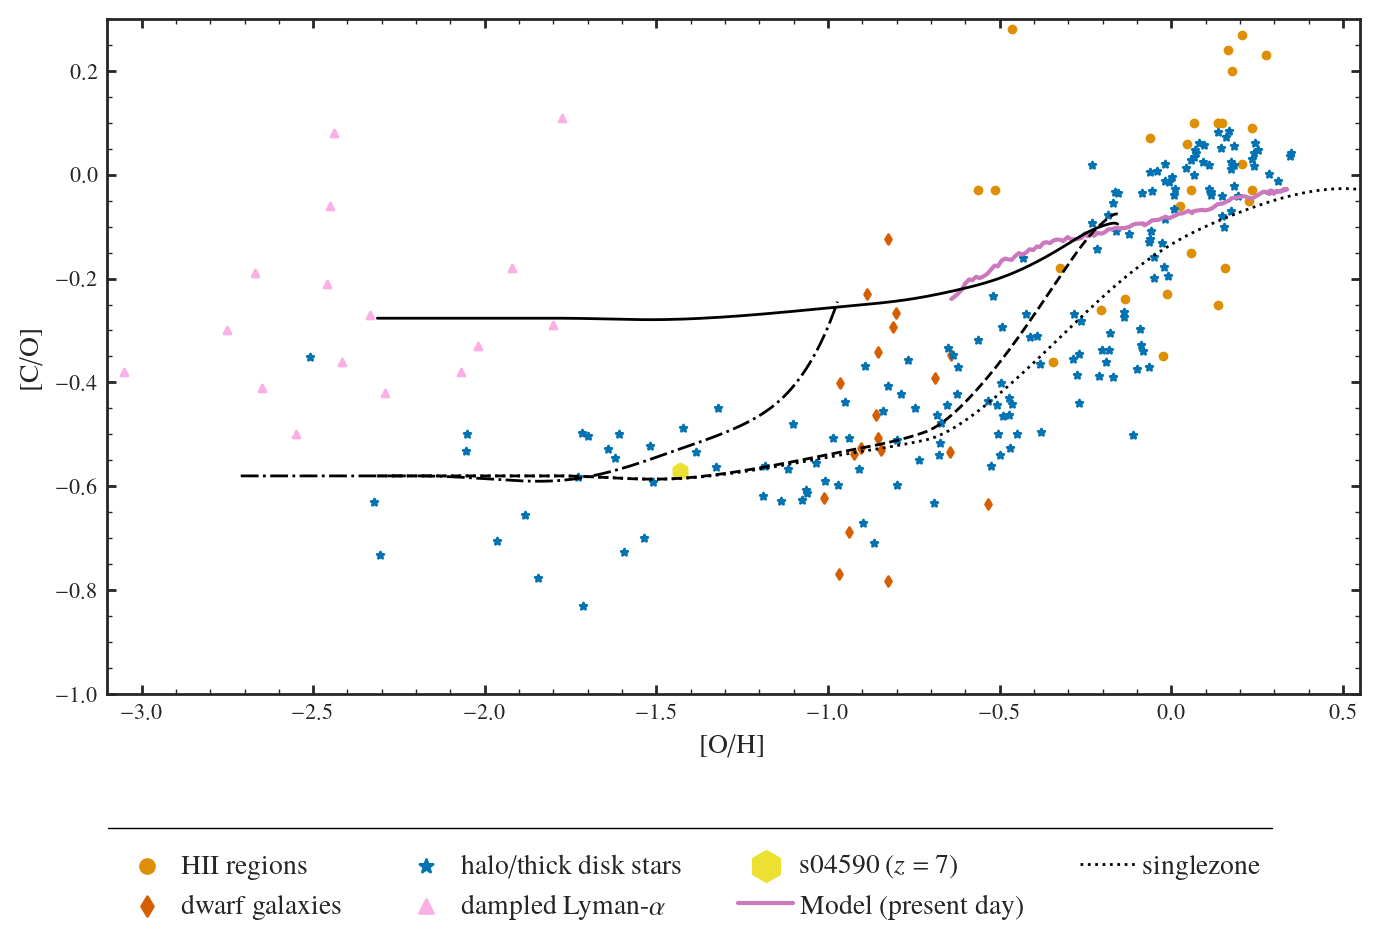

In [19]:
fig = plt.figure(figsize=(7, 4))


# first plots
plot_all()
plot_errorbars()


# JWST
s04590_x = gcem.eps_to_brak(7.12, "o")
s_y = gcem.log_to_brak(-0.83, "c", "o")
plt.scatter([-1.43], [-0.57], marker="h", s=30, label="s04590 ($z=7$)", color=arya.style.COLORS[8])


# fiducial
surp.plots.plot_annulus_at_t(fiducial, "O_H", "C_O", label="Model (present day)", zorder=3, lw=1.5, color=arya.style.COLORS[4])
# fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model ($t=2$ Gyr)", zorder=3, lw=2, color=arya.style.COLORS[4])


#singlezone
for i in range(len(sz_models)):
    out = sz_models[i]
    if i == 0:
        label="singlezone"
    else:
        label=""
    plt.plot(out.O_H, out.C_O, label=label, color="k", 
             lw=1, zorder=4, ls=[":", "--", "-."][i])

plt.plot(sz_fiducial.O_H, sz_fiducial.C_O, label=label, color="k", 
         lw=1, zorder=4)



plt.ylim(-1, 0.3)
plt.xlim(-3.1, 0.55)


lab = plt.xlabel(r"[O/H]")
plt.ylabel(r"[C/O]")

leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4, markerscale=2)
box1 = leg.get_tightbbox()
box2 = lab.get_tightbbox() 

t1 = box1.transformed(fig.transFigure.inverted())
t2 = box2.transformed(fig.transFigure.inverted())
ym = (t2.y0 + t1.y1)/2

fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))


plt.tight_layout()

plt.savefig("figures/summary.pdf")